# IFT 599/799 – Science des données

## TP3 : Analyse de données par le clustering

Ce TP porte sur  une application de clustering pour analyser l’ensemble de données appelé "Adult". Il consiste à développer un algorithme de clustering permettant de mettre en évidence des clusters qui représentent le mieux possible l'une des deux classes. A savoir, un cluster représente bien une classesi les deux conditions suivantes sont satisfaites : (1) la très grande majorité des "personnesadulte" de l’ensemble d’apprentissage, si ce n’est pas la totalité, du cluster appartiennent à laclasse ; (2) la très grande majorité des "personnes adulte" de l’ensemble de test, si ce n’est pasla totalité, appartenant au cluster appartiennent à la classe également. 

## Introduction : compréhension des données


In [1]:
## Dans un premier temps, il est nécessaire d'importer les différente librairies utilisées
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import seaborn as sns
import pandas as pd
pd.reset_option('^display.', silent=True)
pd.set_option('display.notebook_repr_html', True)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from scipy.spatial import distance
import sklearn
import matplotlib

# Changement des paramètres par défaut de seaborn et des figures
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [10, 8]
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set()

In [2]:
## On lit ensuite les données qui sont sous un format csv, séparées par une virgule.
## Afin d'avoir un pré-traitement cohérent, nous regroupons les données de test et les 
## données d'entraînement dans un même jeu de données, que nous reséparons par la suite. 

columns_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
                 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
                 'income']


data_train = pd.read_csv("data/csv/adult_data.csv", sep=',', na_values='␣', encoding='latin-1', names=columns_names)
data_test = pd.read_csv("data/csv/adult_test.csv", sep=',', na_values='␣', encoding='latin-1', skiprows=1, 
                        names=columns_names)

data = pd.concat([data_train, data_test], axis=0)
print("Forme du jeu de données adult.csv : ",data.shape)


Forme du jeu de données adult.csv :  (48842, 15)


La forme de notre jeu de données nous montre qu'il possède 48842 objets chacun composé de 15 attributs (détaillés ci-après). Ce jeu de données comporte les données d'entraînement ainsi que les données de test.


In [3]:
## Pour exemple, on peut visualiser 5 objets pris aléatoirement dans jeu de données: 
data.sample(frac=0.7).head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
17720,25,Private,185942,Masters,14,Never-married,Prof-specialty,Own-child,White,Female,0,0,40,United-States,>50K
911,38,Private,278924,Some-college,10,Divorced,Craft-repair,Not-in-family,White,Male,0,0,44,United-States,<=50K
20373,28,Private,205337,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,<=50K
11413,49,Self-emp-inc,140644,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,5013,0,45,United-States,<=50K.
21394,22,?,121070,Some-college,10,Never-married,?,Own-child,White,Male,0,0,35,United-States,<=50K


Chaque ligne correspond ainsi à un objet de notre jeu de données, et chaque colonne un attribut. On peut observer que ces attributs correspondent à "âge" qui est une variable numérique représentant l'âge de la personne, "corkclass" une variable catégorique représentant le type de métier, "fnlwgt" un certain poids associé à un individu en fonction de certains critères, "education" le degré d'éducation de la personne, "education_num" un numéro associé au type d'éducation de la personne, "marital status" une varible catégorique indiquant le statut marital de la personne, "occupation" le type de métier effectué, "relationship" le type de relations qui le caractérise, "race" sa couleur de peau, "sex" son genre, "capital_gain" et "capital_loss" des variables continues caractérisant son revenu, "hours_per_week" le nombre d'heures effectuées par semaine au travail, "native_country" le pays natal de la personne et enfin "income" qui est la variable catégorique que l'on va souhaiter prédire : le revenu de la personne qu'il soit supérieur ou inférieur à 50 000$ l'année.  

In [4]:
## On va supprimer l'ensemble des données dupliquées.
data = data.drop_duplicates(subset=None, keep='first', inplace=False)
data.shape

(48813, 15)

Il y avait 29 données dupliquées que nous avons ainsi supprimées du jeu de données. 

In [5]:
## On va créer un DataFrame concernant la variable cible, afin d'obtenir d'avantage d'informations
prediction = pd.DataFrame(data['income'])
prediction = prediction.replace(to_replace=" <=50K.", value=0)
prediction = prediction.replace(to_replace=" <=50K", value=0)
prediction = prediction.replace(to_replace=" >50K.", value=1)
prediction = prediction.replace(to_replace=" >50K", value=1)

sup50k = prediction[prediction['income'] == 1]
inf50k = prediction[prediction['income'] == 0]


print("nombre de personnes ayant un salaire supérieur à 50k : ", sup50k.shape[0] )
print("nombre de personnes ayant un salaire inférieure à 50k : ", inf50k.shape[0])

nombre de personnes ayant un salaire supérieur à 50k :  11685
nombre de personnes ayant un salaire inférieure à 50k :  37128


Ainsi, sur l'ensemble du jeu de données, soit 48813 personnes, 11685 possèdent un salaire supérieur à 50 000 dollars (soit environ 24%) et ainsi 76% possèdent un salaire inférieur à 50 000dollars l'année. 

In [6]:
## Désormais nous allons nous intéresser aux valeurs manquantes. 
## Pour pouvoir obtenir des informations sur ces dernières nous allons remplacer 
# les '?' par des NaN. 

data = data.replace(to_replace=' ?', value=np.nan)


def missing_zero_values_table(df):
    """
    La fonction trouvée à l'adresse suivante : 
    https://stackoverflow.com/questions/37366717/pandas-print-column-name-with-missing-values
    nous permet d'avoir un aperçu sur le pourcentage de valeurs manquantes et de 0, 
    les attributs qui y sont associés ainsi que les types de ces attributs.
    """
    zero_val = (df == 0).sum(axis=0)
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
    mz_table = mz_table.rename(
    columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
    mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
    mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
    mz_table['Data Type'] = df.dtypes

    mz_table = mz_table[
        mz_table.iloc[:,3] != 0].sort_values(
    '% Total Zero Missing Values', ascending=False).round(1)

    print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n" 
        "There are " + str(mz_table.shape[0]) +
          " columns that have missing values.")
    return mz_table

In [7]:
missing_zero_values_table(data[:data_train.shape[0]])

Your selected dataframe has 15 columns and 32561 Rows.
There are 5 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
capital_loss,31042,0,0.0,31042,95.3,int64
capital_gain,29845,0,0.0,29845,91.7,int64
occupation,0,1847,5.7,1847,5.7,object
workclass,0,1840,5.7,1840,5.7,object
native_country,0,583,1.8,583,1.8,object


Ainsi, on remarque que l'attribut "capital_loss" possède plus de 95% de ses valeurs à zéro, tout comme "capital_gain" qui possède 91.7% de ses valeurs également nulles. Ces deux caractéristiques sont des caractéristiques continues. Les caractéristiques "occupation", "workclass" et "native_country" sont elles des variables catégoriques pour lequelles il y a respectivement 5.7%, 5.7% et 1.8% de données manquantes.

## Premières partie : pré-processing des données 

Le pré-processing que nous allons effectuer consiste en la supression des attributs non pertinents, en la conversion de l'ensemble des valeurs continues en variables catégoriques (bien que l'inverse aurait également pu être effectué) et enfin le traitement des données manquantes. 

### 1) Supression des caractéristiques non pertinentes 

In [8]:
## Observons de façon plus poussée la répartition des caractéristiques "capital_loss"
## et "capital_gain" grâce à la fonction describe() 

capital_loss_non_zero = data['capital_loss'].loc[data_train['capital_loss'] > 0]
capital_gain_non_zero = data['capital_gain'].loc[data_train['capital_gain'] > 0]

loss_described = capital_loss_non_zero.describe().T.head()
gain_described = capital_gain_non_zero.describe().T.head()

description_capital = pd.DataFrame(pd.concat([loss_described, gain_described],axis=1))

description_capital.T.head()

,count,mean,std,min,25%
capital_loss,2283.0,1274.112133,925.836193,0.0,0.0
capital_gain,4055.0,9068.429100,19741.094649,0.0,0.0


On remarque que, comme on l'a vu précédemment, bien plus de 25% des valeurs sont à 0 pour les deux attributs. Ainsi, les valeurs non nulles peuvent être considérées commes des "outliers". Il n'est donc pas pertinent de garder ces caractéristiques dans le jeu de données.

In [9]:
# On supprime du jeu de données les caractéristiques capital_loss et capital_gain
data = data.drop(['capital_loss', 'capital_gain'], axis=1, inplace=False)

On a remarqué que les deux caractéristiques "education" et "education_num" du jeu de données étaient relativement semblables. Il serait pertinent de visualiser ces dernières. 

In [10]:
education = pd.DataFrame(data['education'])
education_num = pd.DataFrame(data['education_num'])
education = pd.concat([education.reset_index(drop=True),education_num.reset_index(drop=True)], axis=1)
education.head(15)

,education,education_num
0,Bachelors,13
1,Bachelors,13
2,HS-grad,9
3,11th,7
4,Bachelors,13
5,Masters,14
6,9th,5
7,HS-grad,9
8,Masters,14
9,Bachelors,13


On remarque que la caractéristique "education_num" apporte exactement la même information que l'attribut "education" : un chiffre représente un type de scolarité. Ainsi, garder les deux caractéristique n'est pas pertinent car cela apporte de l'information redondante.

In [11]:
# On a effectué le choix de supprimer la caractéristique "education" car pour pouvoir entraîner le clustering
# nous aurions dû transformer la variable "education" en une variable ressemblant à "education_num"

data = data.drop(['education'], axis=1, inplace=False)

### 2) Traitement des valeurs manquantes

Désormais il est nécessaire de transformer les données manquantes. Nous avons vu précédemment que ces données manquantes se trouvaient pour la plupart dans les caractéristiques "capital_loss" et "capital_gain" que nous avons supprimées, mais également dans les caractéristiques "occupation, "workclass" et "native_country" qui sont des variables catégoriques. Ainsi, une chose pertinente à faire et de remplacer les valeurs manquantes de ces caractéristiques par leur mode. 

In [12]:
## Dans un premier temps, on va visualiser le mode de chacune de ces variables. 

print("Mode de occupation : ", data[:data_train.shape[0]]['occupation'].mode()[0])
print("Mode de workclass : ", data[:data_train.shape[0]]['workclass'].mode()[0])
print("Mode de native country : ", data[:data_train.shape[0]]['native_country'].mode()[0])

Mode de occupation :   Prof-specialty
Mode de workclass :   Private
Mode de native country :   United-States


In [13]:
# Nous remplacons désormais toutes les fois où "?" apparaît par le mode de la caractéristique correspondante.
data['occupation'].replace(to_replace=" ?", value='Prof-specialty', inplace=True)
data['workclass'].replace(to_replace=" ?", value='Private', inplace=True)
data['native_country'].replace(to_replace=" ?", value='United-States', inplace=True)

### 3) Conversion des variables continues en variables catégoriques

Finalement, la fin du pré-processing consiste à transformer l'ensemble des variables continues en variables catégoriques. Pour faire cela, nous nous sommes basés sur une approche heuristique par l'observation de la distribution de ces variables.

In [14]:
## On récupère l'ensemble des données continues pour les transformer en variables catégoriques qui sont
## "age", "fnlwgt" et "hours_per_week". 

age = pd.DataFrame(data[:data_train.shape[0]]['age'])
fnlwgt = pd.DataFrame(data[:data_train.shape[0]]['fnlwgt'])
hours_per_week = pd.DataFrame(data[:data_train.shape[0]]['hours_per_week'])

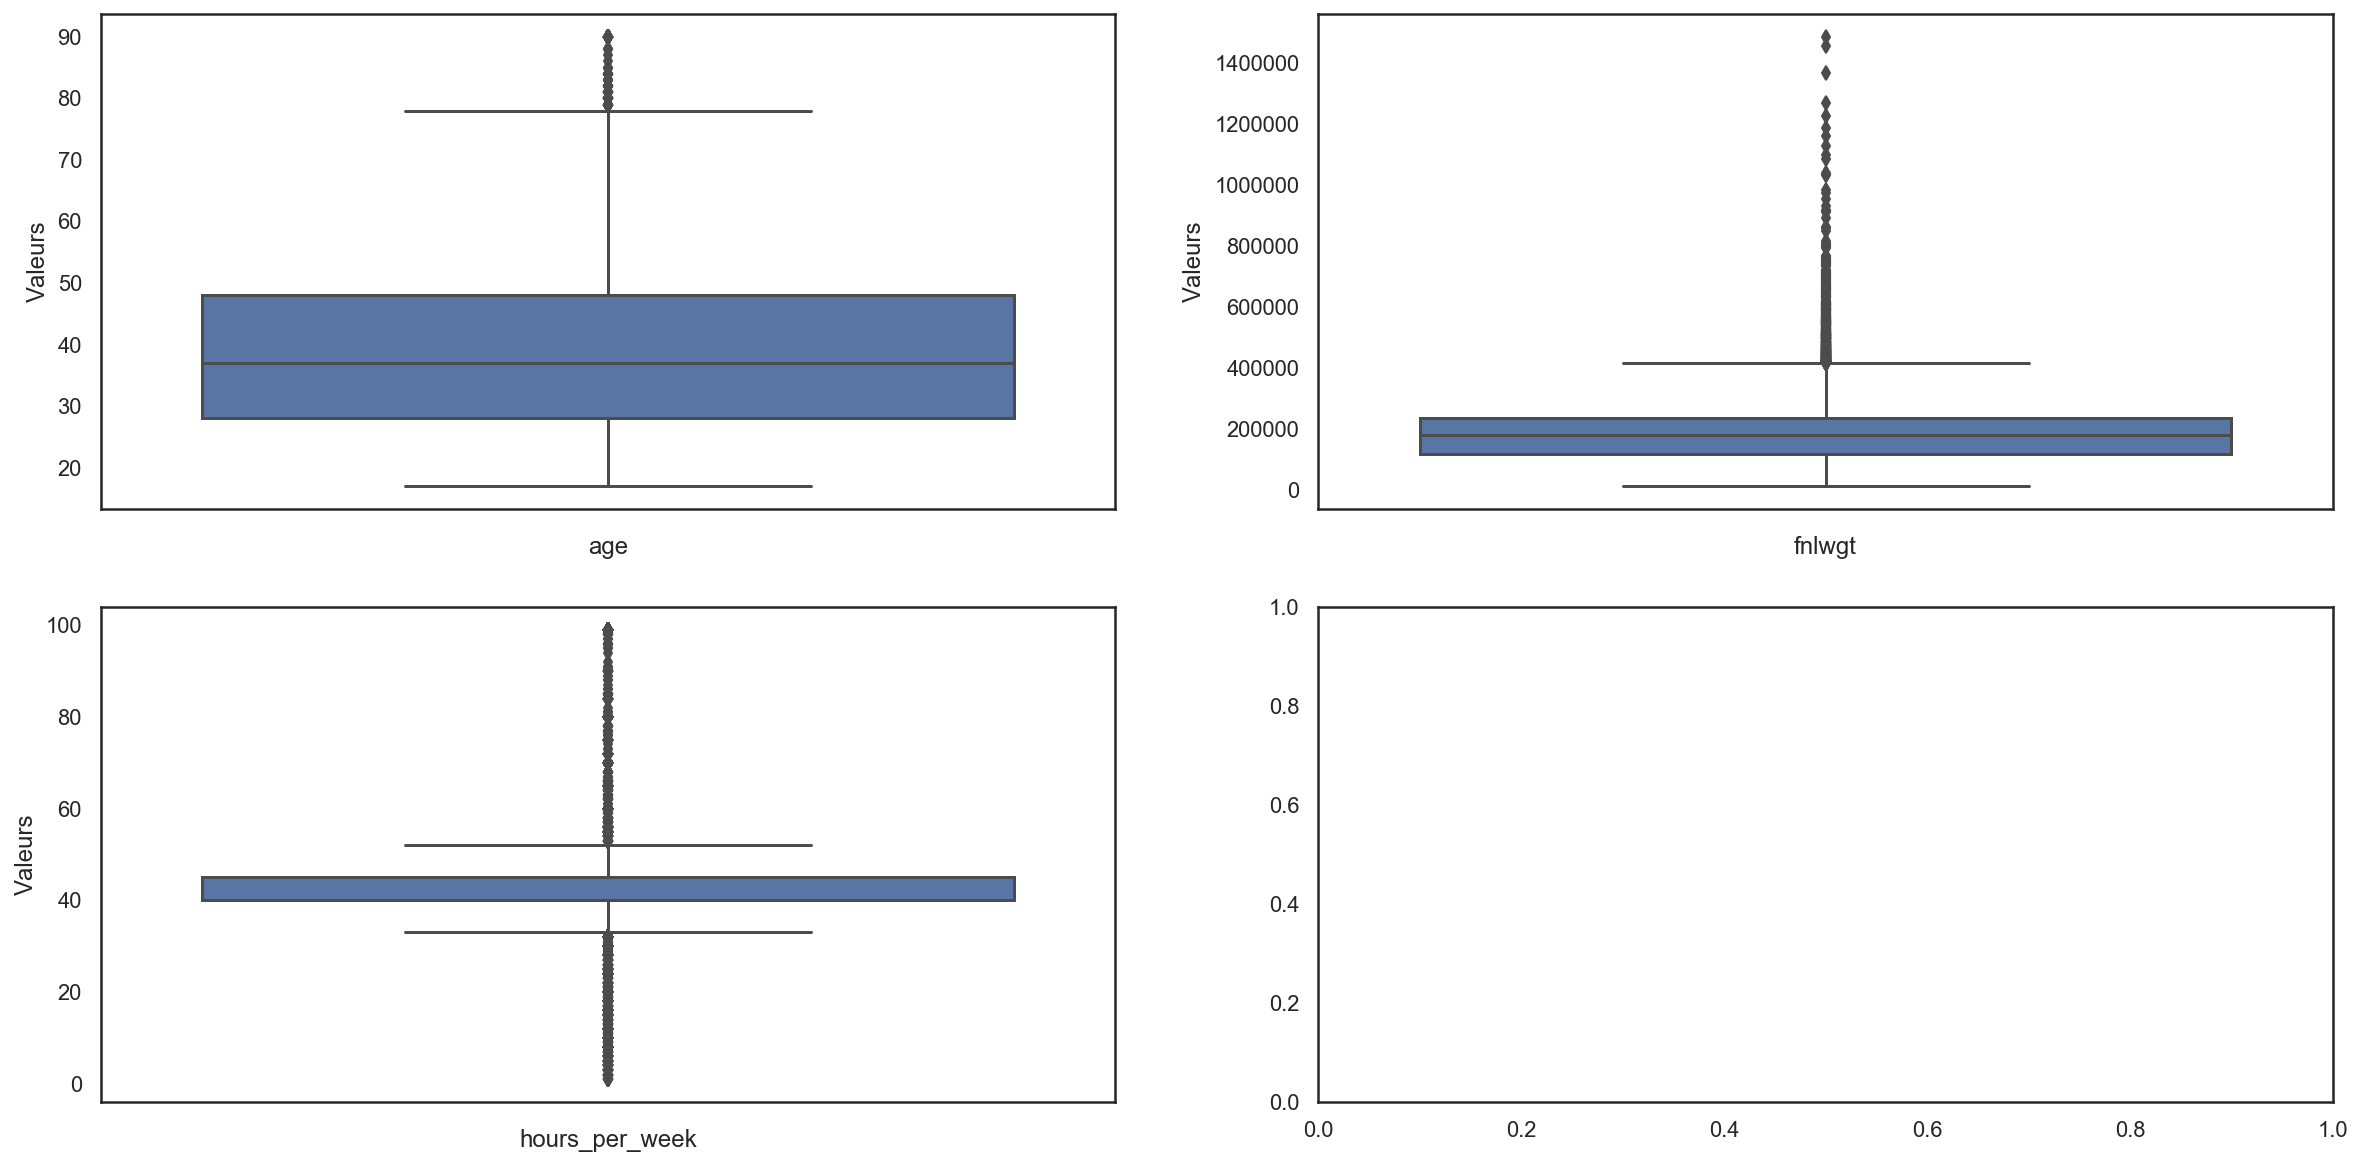

In [15]:
sns.set(style="white")
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

dict1 = {0:(age, axes[0, 0],"age"),
         1:(fnlwgt,axes[0, 1],"fnlwgt"),
         2:(hours_per_week,axes[1, 0],"hours_per_week")
        }

for i in range(3):
    sns.boxplot( 
        y=dict1[i][0],
        ax=dict1[i][1],
        ).set(
        xlabel=dict1[i][2], 
        ylabel='Valeurs',
        )

plt.show()

D'après ces boxplots, on remarque que chacune de ces caractéristiques possèdent un certain nombre de données aberrantes.

In [16]:
# Désormais on va afficher dans un tableau la description de la distribution pour chacune des variables. 

age_described = age.describe().T.head()
fnlwgt_described = fnlwgt.describe().T.head()
hours_per_week_described = hours_per_week.describe().T.head()

age_fnlwgt = pd.concat([age_described, fnlwgt_described])
fnlwgt_education = pd.concat([age_fnlwgt,hours_per_week_described])
description = pd.DataFrame(fnlwgt_education)

description.head()

,count,mean,std,min,25%,50%,75%,max
age,32561.0,38.585946,13.638589,17.0,28.0,37.0,48.0,90.0
fnlwgt,32561.0,189786.693898,105554.833291,12285.0,117814.0,178356.0,236994.0,1484705.0
hours_per_week,32561.0,40.436780,12.346741,1.0,40.0,40.0,45.0,99.0


Ainsi, on va créer nos bins en s'appuyant de cette distribution. De plus, comme il appraît une relation d'ordre pour chacune des variables que nous considérons, nous n'allons pas transformer ces variables en vecteurs "one-hot".

In [17]:
data.to_numpy()

# On cut les datas en remplaçant chaque bien par la valeur de label correspondant
age = pd.cut(data.age,bins=[0,14,28,37,48,70,100],labels=[0,1,2,3,4,5])
fnlwgt = pd.cut(data.fnlwgt,bins=[0, 117830, 178356, 236993, 1500000],labels=[0,1,2,3])
hours_w = pd.cut(data.hours_per_week,bins=[0,20,40,45,100],labels=[0,1,2,3])

age = pd.DataFrame(age)
fnlwgt = pd.DataFrame(fnlwgt)
hours_w = pd.DataFrame(hours_w)
data = data.drop(['age', 'fnlwgt', "hours_per_week"], axis=1, inplace=False)

Concernant la variable "native_country", on remarque que la grande majorité des personnes proviennent des "Etats-Unis". Néanmoins il existe 37 valeurs possibles pour cette caractéristique. Ce que nous allons faire c'est regrouper les différents pays en les regroupant ensemble en "asie_centr", "asie_est", "amerique_sud", "europe_ouest" et "europe_est". 

In [18]:
data = data.replace(to_replace=[" Cambodia", " China", " Hong", " Laos", " Thailand",
               " Japan", " Taiwan", " Vietnam"], value="Asie_est")
data = data.replace(to_replace=[" India", " Iran"], value="Asie_centre")
data = data.replace(to_replace=[" Cuba", " Guatemala", " Jamaica", " Nicaragua", 
                     " Puerto-Rico",  " Dominican-Republic", " El-Salvador", 
                     " Haiti", " Honduras", " Mexico", " Trinadad&Tobago"], value="amerique_centre")
data = data.replace(to_replace=[" Ecuador", " Peru", " Columbia"], value="amerique_sud")
data = data.replace(to_replace=[" England", " Germany", " Holand-Netherlands", " Ireland", 
                 " France", " Greece", " Italy", " Portugal", " Scotland"], value="europe_ouest")
data = data.replace(to_replace=[" Poland", " Yugoslavia", " Hungary"], value="europe_est")

Désormais il est nécessaire de transformer les variables catégoriques pour lesquelles il n'existe pas de relation d'ordre par des vecteurs one_hot, afin que l'on puisse les rentrer dans l'algorithme de clustering. 

In [19]:
# On transforme chacune des données catégoriques en one_hot vectors
workclass= pd.DataFrame(data['workclass'])
workclass= pd.get_dummies(workclass,prefix=['workclass'])

marital_status= pd.DataFrame(data['marital_status'])
marital_status = pd.get_dummies(marital_status,prefix=['marital_status'])

occupation= pd.DataFrame(data['occupation'])
occupation = pd.get_dummies(occupation,prefix=['occupation'])

relationship= pd.DataFrame(data['relationship'])
relationship = pd.get_dummies(relationship,prefix=['relationship'])

race= pd.DataFrame(data['race'])
race= pd.get_dummies(race,prefix=['race'])

sex= pd.DataFrame(data['sex'])
sex = pd.get_dummies(sex,prefix=['sex'])

native_country= pd.DataFrame(data['native_country'])
native_country = pd.get_dummies(native_country,prefix=['native_country'])

# On concatène l'ensemble des données afin d'obtenir finalement un dataFrame comprenant
# l'ensemble des données préprocessées. 
workclass_status = pd.concat([workclass, marital_status], axis=1)
status_occupation = pd.concat([workclass_status, occupation], axis=1)
occupation_relationship = pd.concat([status_occupation, relationship], axis=1)
relationship_race = pd.concat([occupation_relationship, race], axis=1)
race_sex = pd.concat([relationship_race, sex], axis=1)
sex_country = pd.concat([race_sex, native_country], axis=1)
country_age = pd.concat([sex_country, age], axis=1)
age_fnlwgt = pd.concat([country_age, fnlwgt], axis=1)
fnlwgt_hours = pd.concat([age_fnlwgt, hours_w], axis=1)
data = pd.concat([fnlwgt_hours, prediction], axis=1)

In [20]:
data.head()

,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,marital_status_ Divorced,marital_status_ Married-AF-spouse,...,native_country_Asie_centre,native_country_Asie_est,native_country_amerique_centre,native_country_amerique_sud,native_country_europe_est,native_country_europe_ouest,age,fnlwgt,hours_per_week,income
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,3,0,1,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,4,0,0,0
2,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,3,2,1,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,4,2,1,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,3,1,0


On remarque que désormais, le jeu de données comporte 57 caractéristiques, composées de 0 ou de 1 dans le cas de one-hot vectors, ou de nombres entre 0 et 5 dans le cas de caractéristiques pour lesquelles il existe une relation d'ordre.

Finalement il est nécessaire de reséparer les données d'apprentissage des données d'entraînement.

In [21]:
# On sépare nos données en deux.
data_train = data[:data_train.shape[0]]
data_test = data[data_train.shape[0]:]

# On récupère les labels de prédiction pour l'entraînement
labels_train = data_train["income"]
data_train = data_train.drop(["income"], axis=1, inplace=False)
labels_train = labels_train.to_numpy()
labels_train = pd.DataFrame(labels_train.reshape(32561))

# On récupère les labels de prédiction pour le test
labels_test = data_test["income"]
data_test = data_test.drop(["income"], axis=1, inplace=False)
labels_test = labels_test.to_numpy()
labels_test = pd.DataFrame(labels_test.reshape(16252))

### 4) Standardisation des données 

Nous allons standardiser nos données afin que l'ensemble de nos variables dans nos données soient à la même échelle. En effectuant ce pre-processing nous ne perdons aucune information, mais néanmoins cela est important lorsque l'on fait du clustering, car les clusters sont définis en se basant sur des distances.

In [22]:
# On importe la bibliothèque de preprocessing de scikit-learn
from sklearn import preprocessing

columns = data.columns

#On effectue le preprocessing sur les données de test
data_test = pd.DataFrame(preprocessing.scale(data_test))
data_test.columns = columns[:-1]

#On effectue le preprocessing sur les données d'entraînement
data_train = pd.DataFrame(preprocessing.scale(data_train))
data_train.columns = columns[:-1]

In [23]:
# On exporte l'ensemble de nos données en csv
data_test.to_csv("data/csv/preprocessed/data_test.csv", index=False, header=True)
data_train.to_csv("data/csv/preprocessed/data_train.csv", index=False, header=True)
labels_train.to_csv("data/csv/preprocessed/labels_train.csv", index=False, header=True)
labels_test.to_csv("data/csv/preprocessed/labels_test.csv", index=False, header=True)

## Deuxième partie : implémentation d'un algorithme de clustering

Pour cette partie, nous avons choisi d'implémenter une approche par partition en implémentant un algorithme kmeans. Nous avons choisi cet algorithme pour les nombreux avantages qu'il propose : le fait qu'il soit simplement implémentable, adapté à des datasets de grande dimensions, qu'il garantisse la convergence, qu'il puisse s'adapter facilement à de nouveaux exemples mais aussi car il peut être généralisé à des clusters de tailles et de formes différentes. 
Pour faire cela, nous avons utilisé la classe Kmeans de la bibliothèque Python "scikit-learn", et avons procédé en différentes étapes. 
Dans un premier temps, nous avons implémentées trois méthodes, nous permettant de calculer l'erreur de nos clusters en considérant les labels données dans notre jeu de données, une fonction nous permettant d'afficher l'erreur calculée en fonction d'un certain nombre de clusters initiaux, une fonction nous permettant de déterminer le meilleur paramètre k (nombre de clusters initiaux) en fonction d'un tableau d'erreurs et finalement une fonction qui teste les trois citées précédemment en faisant varier le nombre de clusters de départ. 

Pour cette partie, nous avons implémentée une erreur de test et une erreur d'entraînement en considérant que nous avons bien à notre disposition les labels attendus pour les données d'entraînement et les données de test. Il est également important de garder en mémoire qu'un cluster représente bien une classesi les deux conditions suivantes sont satisfaites : (1) la très grande majorité des "personnesadulte" de l’ensemble d’apprentissage, si ce n’est pas la totalité, du cluster appartiennent à laclasse ; (2) la très grande majorité des "personnes adulte" de l’ensemble de test, si ce n’est pasla totalité, appartenant au cluster appartiennent à la classe également. 
Ainsi, ces erreurs ont été calculées de la façon suivante : 
- erreur d'entraînement : nombre d'individus du cluster n'appartenant pas à la classe représentée par celui-ci (pour rappel, un cluster représente une classe après un vote majoritaire sur tous ses individus). 
- erreur de test : nombres d'individus du jeu de données non bien classés (après assignation à un cluster, on regarde la classe prédite par l'algorithme).


In [24]:
from sklearn.cluster import KMeans
from sklearn import metrics
from time import time

def error_kmeans_supervised(data_train, labels_train, labels_test, data_test, k):
    """
    Cette fonction retourne l'erreur d'entraînement et l'erreur de test
    pour un k donné, en considérant que l'on a à notre disposition les labels
    attendus pour les données de test et pour les données d'entraînement. 
    """
    # Dans un premier temps on initialise les tableaux
    # taille totale contient le nombre d'individus par cluster
    taille_totale = np.zeros(k)
    # Error_test contient l'erreur finale ie le nombre d'individus de test mal classés
    error_test = np.zeros(k)
    # classe_rpz_per_cluster contient le vote majoritaire par cluster (ie la classe de chacun des cluster) 
    classe_rpz_per_cluster = np.zeros(k)
    # Labels_test contient tous les labels à prédire pour chacune des données du jeu de test
    labels_test = labels_test.to_numpy()
    # Labels_train contient tous les labels à prédire pour chacune des données du jeu d'entrainement
    labels_train = labels_train.to_numpy()
    # On effectue l'algorithme kmeans pour le k considéré. 
    kmeans = KMeans(n_clusters=k, init='random', n_init=100, max_iter=150, random_state=0, verbose=0)  
    # On récupère un tableau correspondant aux clusters affecté pour chaque donnée d'entraînement
    res_train = kmeans.fit(data_train)
    for i in range(len(res_train.labels_)):
       # if i%10000==0:
       #     print("indiv",i,"sur",len(res_train.labels_))
        out = labels_train[i]
        classe_rpz_per_cluster[res_train.labels_[i]] += out
        taille_totale[res_train.labels_[i]] += 1
    # On verifie bien que l'ensemble des données d'entraînement a été pris en compte
    assert np.sum(taille_totale) == data_train.shape[0]
    error_res = classe_rpz_per_cluster.astype(np.int32) / taille_totale
    taille_totale = taille_totale / data_train.shape[0]
    classe_in_cluster = [1 if elt > 0.5 else 0 for elt in error_res]
    error_totale = [elt if elt < 0.5 else (1 - elt) for elt in error_res]
    error_totale = error_totale * taille_totale
    res_test = res_train.predict(data_test)
    classe_per_cluster_test = np.array([classe_in_cluster[elt] for elt in res_test])
    error_test = np.sum(classe_per_cluster_test != np.squeeze(labels_test))
    error_totale = [0 if np.isnan(error_totale[i]) else error_totale[i] for i in range(len(error_totale))]
    return np.sum(error_totale), error_test/data_test.shape[0]    


def plot_error(error_test_tab, error_train_tab, k_values, supervised=True):  
    """
    Cette fonction permet d'afficher dans une figure l'erreur de test et
    d'entraînement dans le cas où l'on considère que l'on a accès aux labels,
    et sinon la distance moyenne aux clusters (ssd) dans le cas où l'on n'a pas 
    accès aux différents labels. 
    """
    max_k = np.amax(k_values)
    error_train_tab = np.asarray(error_train_tab)
    error_test_tab = np.asarray(error_test_tab)
    plt.figure(figsize=(10, 10))
    min_error_train = np.amin(error_train_tab)
    min_error_test = np.amin(error_test_tab)

    plt.subplot(2, 1, 1)
    if supervised:
        label_test = "Error test"
        label_train = "Error train"
        title_test = 'Minimal test error: {:.2f}%'.format(min_error_test)
        title_train = 'Minimal train error: {:.2f}%'.format(min_error_train)
    else:
        label_test = "SSD test"
        label_train = "SSD train"
        title_test = 'Minimal ssd test: {:.2f}%'.format(min_error_test)
        title_train = 'Minimal ssd train: {:.2f}%'.format(min_error_train)
        
    plt.plot(k_values, error_train_tab, '.--', label=label_train)
    title = title_train
    plt.ylabel('error')
    plt.title(title)        
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(k_values, error_test_tab, '.--', label=label_test)
    title = title_test
    plt.xlabel('value of k')
    plt.ylabel('Error')
    plt.title(title)
    plt.legend()
    
    
def kmean_best_k(error_train_tab, error_test_tab, data_train, labels_train, labels_test):
    """
    Cette fonction permet de retourner la meilleure valeur du nombre de cluster 
    initiaux pour l'algorithme de kmeans en fonction des erreurs d'entraînement
    """
    # On récupère l'indice pour lequel l'erreur est minimale
    indice_min_error = np.argmin(error_train_tab)
    # On récupère le k pour lequel l'erreur est minimale
    best_k = k_values[indice_min_error]   
    # On relance l'algorithme kmeans avec la meilleure valeur trouvée de k pour
    # obtenir l'erreur finale sur le jeu de test
    error_train, error_test = error_kmeans_supervised(data_train, labels_train, labels_test, data_test, best_k)
    print("Avec le meilleur paramètre k : ",best_k, "l'erreur de test du clustering sur le jeu de test est: {:.2f}%"
          .format(error_test))
    return best_k


def choose_plot_best_k(data_train, labels_train, labels_test, data_test, k_values):
    """
    Cette fonction permet de tester l'algorithme kmeans pour différentes valeurs
    de k, de garder les erreurs dans un tableau, et grâce aux fonctions précédentes 
    d'afficher les différentes erreurs en fonction de k et de retourner la valeur de k
    optimale. 
    """
    # On initialise les tableaux d'erreurs
    error_test_tab = []
    error_train_tab = []
    # On parcourt l'ensemble des k que l'on souhaite tester
    for k in k_values:
        # On récupère l'erreur sur le jeu d'entraînement et le jeu de test
        error_train, error_test = error_kmeans_supervised(data_train, labels_train, labels_test, data_test, k)
        # On incrémente les tableaux par les erreurs trouvées
        error_test_tab.append(error_test)
        error_train_tab.append(error_train)
    # On affiche les erreurs en fonction des différentes valeurs de k
    plot_error(error_test_tab, error_train_tab, k_values)
    # On récupère le k le plus optimal
    return kmean_best_k(error_train_tab, error_test_tab, data_train, labels_train, labels_test)


Avec le meilleur paramètre k :  51 l'erreur de test du clustering sur le jeu de test est: 0.20%


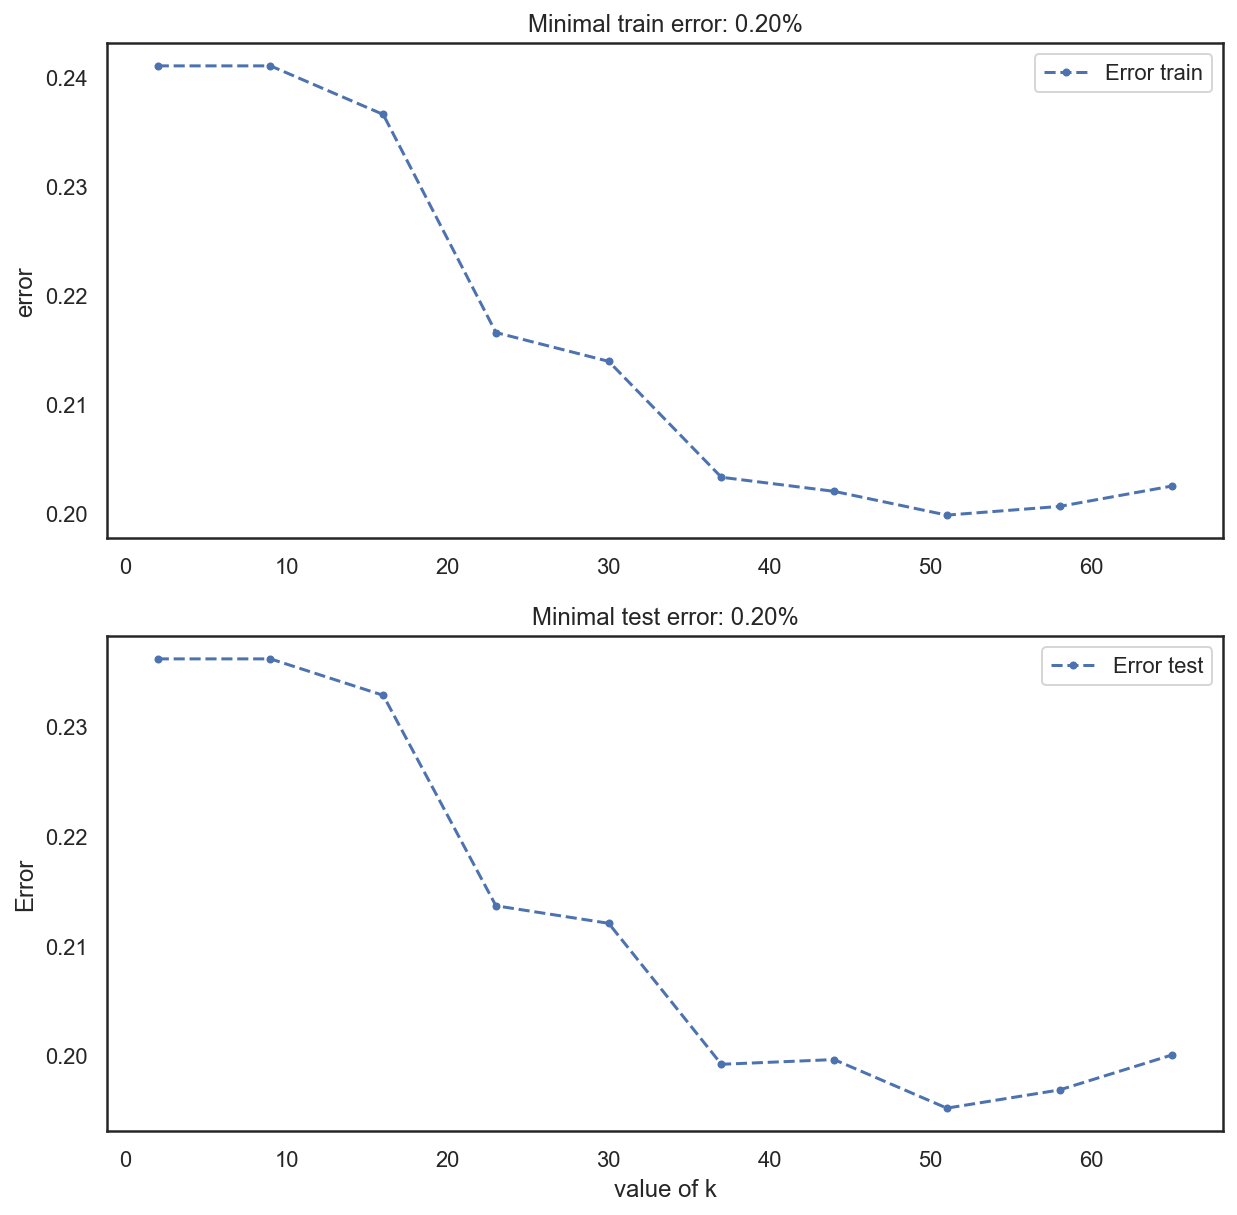

In [25]:
# On test l'algorithme pour 10 valeurs différentes de k
k_values = np.arange(2,72,7)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    best_k = choose_plot_best_k(data_train, labels_train, labels_test, data_test, k_values)

Ainsi, pour ce jeu de données la meilleure valeur de k est 51, avec une erreur de test de 20%, et une erreur d'entraînement d'environ 20% également. On remarque que plus le nombre e clusters initiaux augmente (plus k est grand), moins l'erreur et grande. Cela s'explique par le fait que les deux classes soient très imbalancées (il y a 11685 personnes qui ont un salaire supérieur à 50K tandis qu'il y a 37128 personnes qui possèdent un salaire inférieur à 50K), mais cela s'explique également par la définition d'un bon cluster que nous avons utilisé pour établir nos métriques, à savoir : "Un cluster représente bien une classesi les deux conditions suivantes sont satisfaites : (1) la très grande majorité des "personnesadulte" de l’ensemble d’apprentissage, si ce n’est pas la totalité, du cluster appartiennent à la classe; (2) la très grande majorité des "personnes adulte" de l’ensemble de test, si ce n’est pasla totalité, appartenant au cluster appartiennent à la classe également."

## Troisième partie : séléction des caractéristiques pertinentes

Cette partie consiste à choisir les meilleures variables pour le clustering en ne considérant uniquement la meilleure valeur de k trouvée précédemment. Cela a été effectué en deux étapes différentes : dans un premier temps, en considérant que nous avons accès aux différents labels à prédire pour les données de test ainsi que les données d'entraînement, et dans un second temps en considérant que nous n'avons pas accès à ces informations, ainsi de façon non supervisée. 
Dans les deux cas, la mmême approche a itérative a été développée, à travers un algorithme dit "glouton" : il s’agit de choisir d’abord la meilleure variable individuelle en exécutant le clustering pour chaque variable individuellement, puis la meilleure couple obtenue par la combinaison avec la premiere choisie, puis la meilleure triple obtenue par lacombinaison avec la meilleure couple choisie, etc.
Ce qui va changer à travers les deux étapes sera nos métriques afin de considérer si oui ou non une caractéristique est une bonne caractéristique

### Choix des caractéristiques avec les informations de classe

Afin d'effectuer ce choix, nous nous sommes basés sur les erreurs de test et d'entraînement que nous avons décrit plus haut dans le rapport : 
- erreur d'entraînement : nombre d'individus du cluster n'appartenant pas à la classe représentée par celui-ci (pour rappel, un cluster représente une classe après un vote majoritaire sur tous ses individus). 
- erreur de test : nombres d'individus du jeu de données non bien classés (après assignation à un cluster, on regarde la classe prédite par l'algorithme).

N'ayant pas des ressources suffisamment puissantes pour lancer les algorithmes suivants, nous avons dû faire un compromis entre réduire le nombre de clusters initiaux ou réduire le nombre de données dans le jeu de données qui était à notre disposition. Nous avons effectué le choix de ne garder que 10 000 données pour le jeu d'entraînement et le jeu de test, ce qui nous a paru être suffisamment de données pour bien correspondre aux données réelles, tout en réduisant par trois le temps de calcul effectué. 


In [26]:
def error(columns_train, columns_test, supervised=True):
    """
    Fonction qui retourne l'erreur de test et d'entraînement si on a 
    accès aux labels, et sinon la somme des distances euclidiennes entre chacune 
    des données et le centroïd auquel elle a été assigné dans le cas où on n'a
    pas accès aux labels. 
    """
    if supervised: 
        return error_kmeans_supervised(columns_train, labels_train, labels_test, columns_test, 52)
    else: 
        return ssd_unsupervised(columns_train, labels_train, labels_test, columns_test, 52)
    

def glouton_algorithm(data_train, data_test, labels_train, labels_test, best_k, supervised=True):
    """
    Fonction qui permet de retourner un dataframe de données de test et d'entraînement
    composé uniquement des caractéristiques les plus pertinentes, selon la métrique choisie : 
    l'erreur d'entraînement si l'on a accès aux labels, et sinon la distance aux centroïds
    si l'on ne possède pas cette information. 
    """
    # 2 premières erreures "virtuelles" pour rentrer dans la boucle: 
    errors_selected_features = [100, 99.9999]
    # Tableau de strings correspondant aux noms des colonnes select:
    selected_features = []
    final_dataframe_train = pd.DataFrame()
    final_dataframe_test = pd.DataFrame()
    while errors_selected_features[-1] <= errors_selected_features[-2]:
        current_error = []
        # Création du dataframe sans les caractéristiques :
        if len(errors_selected_features) > 2:
            data_train = data_train.drop([selected_features[-1]], axis=1, inplace=False)
            data_test = data_test.drop([selected_features[-1]], axis=1, inplace=False)
        # Parcourir toutes les colonnes du jeu de données sans features sélectionnées
        for columns in data_train.columns: 
            # Concaténation du dataframe de features sélectionnées avec la colonne courrante
            # Pour le jeu de train:
            if len(errors_selected_features) > 2:
                data_train_temp = pd.concat([data_train[columns], final_dataframe_train], axis=1)
                # Pour le jeu de test:
                data_test_temp = pd.concat([data_test[columns], final_dataframe_test], axis=1)
            else: 
                data_train_temp = data_train[columns].values.reshape(-1,1)
                data_test_temp = data_test[columns].values.reshape(-1,1)
            # On calcule l'erreur pour le groupe de features selectionnées
            error_train_temp = error(data_train_temp, data_test_temp, supervised)[0]
            # On ajoute cette erreur à un tableau de suivi des erreurs pour l'étape courrante:
            current_error.append(error_train_temp)
        # On calcule l'erreur la plus basse et on récupère le nom de la feature selectionné
        best_feature_index = np.argmin(current_error)
        best_feature = data_train.columns[best_feature_index]
        selected_features.append(best_feature)
        if len(errors_selected_features) > 2:
            final_dataframe_train = pd.concat([data_train[best_feature], final_dataframe_train], axis=1)
            # Pour le jeu de test:
            final_dataframe_test = pd.concat([data_test[best_feature], final_dataframe_test], axis=1)
        else:
            final_dataframe_train = data_train[best_feature]
            final_dataframe_test = data_test[best_feature]
        # On update la valeur d'erreur courante
        errors_selected_features.append(np.amin(current_error))
    # On retourne le tableau contenant les noms des features permettant un clustering optimal (supervisé)
    return final_dataframe_train, final_dataframe_test

In [27]:
# On récupère les dataframes composés des meilleures caractéristiques en considérant que l'on
# a accès aux différents labels, avec un nombre initial de cluster best_k, puis on calcule l'erreur
# de test et d'entraînement. 

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    data_train_best_features, data_test_best_features = glouton_algorithm(data_train[:10000], data_test[:10000], 
                                                                          labels_train[:10000], labels_test[:10000], 
                                                                          best_k, True)
    error_train, error_test = error_kmeans_supervised(data_train_best_features, labels_train, 
                                                      labels_test, data_test_best_features, best_k)
    best_features = data_train_best_features.columns
    print("Le meilleur paramètre k est de ", best_k, " centroïds initiaux.")
    print("Avec ce paramètre, les meilleurs caractéristiques choisies sont : ", best_features)
    print("Ces caractéristiques entraînent une erreur d'entraînement de ", error_train, "et une erreur de test de :",
         error_test)


Le meilleur paramètre k est de  51  centroïds initiaux.
Avec ce paramètre, les meilleurs caractéristiques choisies sont :  Index(['native_country_ Outlying-US(Guam-USVI-etc)', 'workclass_ Never-worked',
       'occupation_ Armed-Forces', 'occupation_ Adm-clerical',
       'occupation_ Farming-fishing', 'occupation_ Sales',
       'workclass_ Self-emp-not-inc', 'native_country_ South', 'race_ Other',
       'occupation_ Tech-support', 'occupation_ Exec-managerial',
       'occupation_ Prof-specialty', 'marital_status_ Married-civ-spouse',
       'workclass_ Self-emp-inc'],
      dtype='object')
Ces caractéristiques entraînent une erreur d'entraînement de  0.1797 et une erreur de test de : 0.0001


L'algorithme glouton supervisé nous a permis de conclure qu'avec un nombre initial de 51 centroïds, quatorze caractéristiques ont été determinées. Ces dernières permettent d'obtenir une erreur d'entraînement d'environ 18%, ce qui est relativement moindre comparé à ce que l'on obtenait avec l'ensemble des caractéristiques. On remarque que la plupart des caractéristiques qui ont été gardées correspondent à l'occupation de la personne ou de son travail, ce qui est pertinent car ce sont des caractéristiques qui influent énormèment sur le salaire gagné. 

### Choix des caractéristiques sans les informations de classe

Pour choisir les caractéristiques les plus pertinentes sans avoir d'informations de classe, nous avons choisi d'évaluer la justesse du clustering en nous basant sur la distance d'une donnée au cluster auquel elle a été attribué. Pour cette distance nous avons calculé la distance euclidienne. Ainsi, plus la somme des distances entre les données et les centroïds auxquels elles ont été attribuées augmente, moins le clustering est bon. 
C'est avec cette métrique que nous avons fait la sélection de caractéristiques grâce à l'algorithme glouton. 

In [28]:
def ssd_unsupervised(data_train, labels_train, labels_test, data_test, k):
    """
    Fonction qui retourne la somme des distances euclidiennes entre les données et les
    centroïds auxquels elles ont été attribuées, pour les données de test et les
    données d'entraînement. 
    """
    if data_train.shape[1] >= 2:
        data_train = data_train.to_numpy()
        data_test = data_test.to_numpy()
    # On effectue un clustering sur les données avec k centroïds initiaux
    kmeans = KMeans(n_clusters=k, init='random', n_init=100, max_iter=150, random_state=0, verbose=0)  
    # On récupère les clusters assignés à chacune des données de data_train
    res_train = kmeans.fit(data_train)
    # On récupère les clusters assignés à chacune des données de data_test
    res_test = res_train.predict(data_test)
    # On récupère les positions de chacun des centroïds
    centroids_init = kmeans.cluster_centers_
    # On initialise les tableaux qui comporteront les différentes ssd
    ssd_tab_train = []
    ssd_tab_test = []
    # On transforme nos dataframes en numpy array pour simplifier les calculs
    # On parcours l'ensemble des assignations pour nos données d'entraînement
    for i in range(len(res_train.labels_)):
        # On calcul la distance euclidienne de chaque donnée d'entraînement au cluster auquel elle est assignée
        ssd_train = np.sqrt(np.sum((data_train[i] - centroids_init[res_train.labels_[i]])**2))
        # On rajoute cette distance à notre tableau de distance
        ssd_tab_train.append(ssd_train)
    # On parcours l'ensemble des assignations pour nos données de test
    for i in range(len(res_test)):
        # On calcul la distance euclidienne de chaque donnée de test au cluster auquel elle est assignée
        ssd_test = np.sqrt(np.sum((data_test[i] - centroids_init[res_test[i]])**2))
        # On rajoute cette distance à notre tableau de distance
        ssd_tab_test.append(ssd_test)
    # On somme le contenu des différents tableau et on effectue une moyenne
    ssd_train = np.sum(ssd_tab_train)/len(data_train)
    ssd_test = np.sum(ssd_tab_test)/len(data_test)
    return ssd_train, ssd_test

In [30]:
# On récupère les dataframes composés des meilleures caractéristiques en considérant que l'on
# n'a pas accès aux différents labels, avec un nombre initial de cluster best_k, puis on calcule l'erreur
# de test et d'entraînement. 

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    data_train_best_features, data_test_best_features = glouton_algorithm(data_train[:10000], data_test[:10000], 
                                                                          labels_train[:10000], labels_test[:10000],
                                                                          best_k, False)
    error_train, error_test = ssd_unsupervised(data_train_best_features, labels_train, 
                                                      labels_test, data_test_best_features, best_k)
    best_features = data_train_best_features.columns
    print("Le meilleur paramètre k est de ", best_k, " centroïds initiaux.")
    print("Avec ce paramètre, les meilleurs caractéristiques choisies sont : ", best_features)
    print("Ces caractéristiques entraînent une SSD de ", error_train, " sur le jeu d'entraînement et une SSD de :",
         error_test, " sur le jeu de test. ")

Le meilleur paramètre k est de  51  centroïds initiaux.
Avec ce paramètre, les meilleurs caractéristiques choisies sont :  Index(['relationship_ Other-relative', 'occupation_ Armed-Forces',
       'native_country_ Outlying-US(Guam-USVI-etc)', 'workclass_ Without-pay',
       'workclass_ Self-emp-inc', 'workclass_ Private',
       'workclass_ Never-worked', 'workclass_ Local-gov'],
      dtype='object')
Ces caractéristiques entraînent une SSD de  6.233156989715407e-18  sur le jeu d'entraînement et une SSD de : 0.03668004238111139  sur le jeu de test. 


De façon non supervisée, l'algorithme glouton a determiné que six caractéristiques étaient optimales pour effectuer de bons clusters avec le jeu de données. Ces caractéristiques, tout comme celles définies par l'algorithme glouton de façon supervisé, sont pour la plupart des données représentant le type de travail effectué par une personne ce qui est un des principal facteur influant sur un salaire. On remarque également que les SSD déterminées sont très proches de 0, ce qui n'est pas étonnant car nos données sont pour la plupart des "one-hot-vectors", ce qui influe forcemment sur une distance euclidienne. 

Il est important de garder un oeil critique sur l'ensemble des résultats determinés tout au long de ce travail. Effectivement, chacun des résultat dépend des choix effectués durant le pré-processing, comme par exemple le fait de convertir les données continues en données catégoriques (l'inverse aurait pu être effectué), ou encore la suppression de certaines caractéristiques ou la modification des variables manquantes. De plus, le choix de l'algorithme et des métriques utilisées influence également le résultat obtenu.  
